# ISLR-Python: Ch7 Applied 3

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from patsy import cr, dmatrix
from pandas import scatter_matrix

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

np.set_printoptions(precision=4)

## Import Auto Dataset

In [2]:
df = pd.read_csv('../../../data/Auto.csv', na_values='?')
df = df.dropna() # drop rows with na values
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


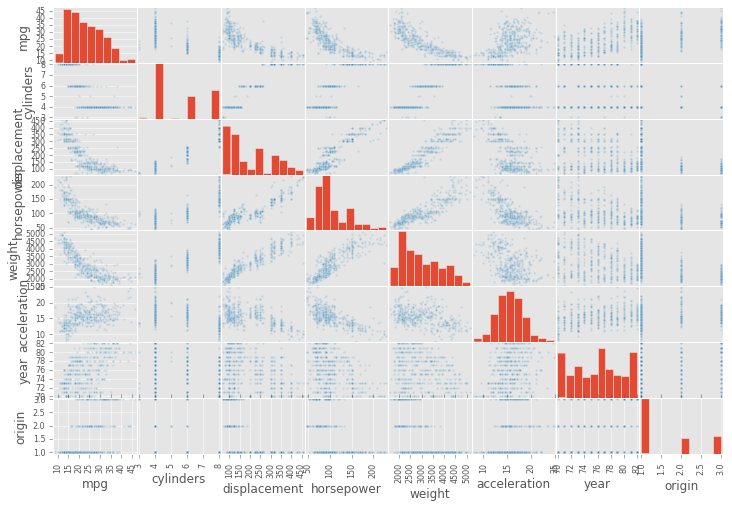

In [3]:
pd.scatter_matrix(df, alpha=0.2, figsize=(12,8));

## Natural Splines

Lets fit a natural spline regressing the acceleration onto the mpg variable. We will use cross-validation to pick the appropriate degrees of freedom for the model and get an estimate for the MSE. To do this we are going to write a function that calls Patsy's dmatrix to construct natural spline design matrices for various degrees of freedom. There is a slight difference in the way Patsy determines degrees of freedom and the way ISLR does. For a natural cubic spline, ISLR deduced that dof = k, where k is the number of knots (see pg 275). However Patsy does not allow for less than 2 degrees of freedom (when centering is on) and 3 dofs (when centering is off). The centering which seems to always be used by ISLR does not change the results but does add one extra knot. It removes the means of each of the resulting columns of the design matrix (see http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.cr )

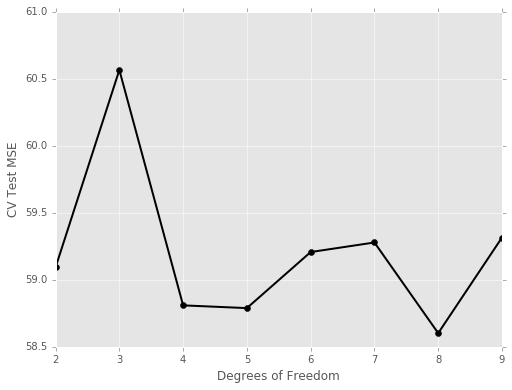

In [6]:
def natural_spline_cv(predictor, response, dofs=list(np.arange(2,10)), kfolds=5):
    """
    Returns an sklearn LinearRegression model object of a spline regression of predictor(pd.Series) onto response 
    (pd.Series). Uses kfold cross-validation and gan optionally return a plot .
    """
    # cross-val scores- array[dof]
    scores = np.array([])
    X_basis = np.array([])
    
    for dof in dofs:
        # natural spline dmatrix
        formula = r'1 + cr(predictor, df=%d, constraints="center")' %(dof)
        X_basis = dmatrix(formula, data={'predictor':predictor}, return_type='matrix')
     
        # model
        estimator = LinearRegression(fit_intercept=False)
        # cross-validation
        scores = np.append(scores, -np.mean(cross_val_score(estimator, X_basis, response, 
                                                            scoring='mean_squared_error', cv=kfolds)))
    # Build CV Error plot
    fig,ax = plt.subplots(1,1, figsize=(8,6))
    ax.plot(dofs, scores, lw=2, color='k', marker='o')
    ax.set_xlabel('Degrees of Freedom')
    ax.set_ylabel('CV Test MSE')
        

scores = natural_spline_cv(df.acceleration, df.mpg)

So the CV plot suggest a 5 degrees of freedom for the natural cubic spline is the best model (though 8 dofs has a lower CV error). 

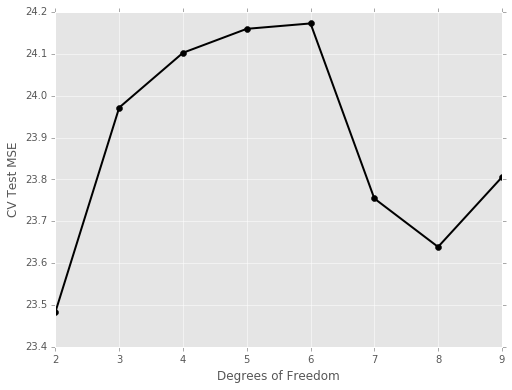

In [5]:
scores = natural_spline_cv(df.weight, df.mpg)

For the weight and MPG 2 degrees of freedom provide a better fit. This is likely because the data is more quadratic than cubic so the natural spline cv function is selecting the least flexible cubic possible.